In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
np.set_printoptions(suppress=True, precision=3, edgeitems=30, linewidth=100000)
from scipy.linalg import expm, logm
import scipy
from numba import jit, njit, NumbaPerformanceWarning

from plot_helpers import plotCoordinateFrame, set_axes_equal

import warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

## Helpers

In [2]:
# Helpers
@njit
def skew(u):
    return np.array([[   0, -u[2],  u[1]],
                    [ u[2],     0, -u[0]],
                    [-u[1],  u[0],     0]])

@njit
def K_from_vec(x):
    K = np.zeros((3,4))
    K[0,0] = x[0]
    K[1,1] = x[1]
    K[0,1] = x[2]
    K[2,2] = 1
    K[0:2,2] = x[3:5]
    return K

@njit
def vec_from_K(K):
    return np.array([K[0,0], K[1,1], K[0,1], K[0,2], K[1,2]])

@njit
def SE3_from_vec(u):
    # https://www.ethaneade.com/lie.pdf
    w = u[:3]
    p = u[3:]
    wx = skew(w)
    theta = np.linalg.norm(w)
    if np.abs(theta) < 0.0001:
        R = np.eye(3) + wx + wx@wx/2 + wx@wx@wx/6
        V = np.eye(3) + wx/2 + wx@wx/6 + wx@wx@wx/24
    
    else:
        A = np.sin(theta) / theta
        B = (1 - np.cos(theta)) / theta**2
        C = (1 - A) / theta**2

        R = np.eye(3) + A*wx + B*wx@wx
        V = np.eye(3) + B*wx + C*wx@wx

    T = np.hstack((R, (V@p).reshape((3,1))))
    T = np.vstack(( T, np.array([[0.0,0,0,1]]) ))
    return T
 
@njit
def vec_from_SE3(T):
    # https://www.ethaneade.com/lie.pdf
    xi = np.zeros(6)
    
    # Log on the rotations
    R = T[:3,:3]
    p = T[:3,3].copy()
    theta = np.arccos( (np.trace(R) - 1) / 2 )
    x = (R - R.T)*theta / (2*np.sin(theta))
    
    xi[0] = R[2,1] - R[1,2]
    xi[1] = R[0,2] - R[2,0]
    xi[2] = R[1,0] - R[0,1]
    
    if theta != 0:
        xi[:3] *= theta / (2*np.sin(theta))
        
    # And on the translation
    wx = skew(xi[:3])
    if theta < .0001:
        V = np.eye(3) + wx/2 + wx@wx/6 + wx@wx@wx/24
    else:
        A = np.sin(theta) / theta
        B = (1 - np.cos(theta)) / theta**2
        C = (1 - A) / theta**2
        V = np.eye(3) + B*wx + C*wx@wx
        
    Vinv = np.linalg.inv(V)
    xi[3:] = Vinv@p
    return xi

@njit
def to_homogen(p):
    return np.hstack(( p, np.ones((p.shape[0], 1)) ))

@njit
def from_homogen(p):
    p /= p[:,-1:]
    return p[:,:-1]

@njit
def to_linear(K, T, P):
    return np.concatenate(( vec_from_K(K), vec_from_SE3(T), P.flatten() ))
    
@njit
def from_linear(x):
    K = K_from_vec(x[0:5])
    T = SE3_from_vec(x[5:11])
    P = x[11:].reshape((N,3))
    return K, T, P

def nder(f, x, eps=1e-6):
    fx = f(x)
    N = x.shape[0]
    M = fx.shape[0]
    d = np.zeros((M,N))
    for i in range(N):
        temp = x.copy()
        temp[i] += eps
        d[:,i] = (f(temp) - fx) / eps
        
    return d

@njit
def f(Kvec, Tvec, P, Tdelta=None):
    if Tdelta is None:
        return K_from_vec(Kvec)@SE3_from_vec(Tvec)@to_homogen(P).T
    else:
        return K_from_vec(Kvec)@SE3_from_vec(Tvec)@SE3_from_vec(Tdelta)@to_homogen(P).T

@njit
def h(K, T, P, T_delta=None):
    if T_delta is None:
        p_homo = K@T@to_homogen(P).T
    else:
        p_homo = K@T@T_delta@to_homogen(P).T
        
    return from_homogen(p_homo.T)

## Jacobians

In [3]:
# projection function
@njit
def pi(K, T, P, Tdelta=None):
    return K@T@np.append(P, 1)

# seperate partials to use in chain rule
@njit
def g_pi(p):
    return np.array([[1/p[2], 0, -p[0]/p[2]**2],
                   [0, 1/p[2], -p[1]/p[2]**2]])

@njit
def pi_K(K, T, P):
    Pp = T@np.append(P,1)
    return np.array([[Pp[0],   0.0, Pp[1], Pp[2],   0.0],
                     [  0.0, Pp[1],   0.0,   0.0, Pp[2]],
                     [  0.0,   0.0,   0.0,   0.0,   0.0]])
    
@njit
def pi_T(K, T, P):
    R = T[:3,:3]
    mat = np.hstack(( -R@skew(P), R ))
    return K[:3,:3]@mat

@njit
def pi_P(K, T, P):
    return K[:,:3]@T[:3,:3]

# chain ruling things
@njit
def h_K(K, T, P):
    return g_pi(pi(K, T, P))@pi_K(K, T, P)

@njit
def h_T(K, T, P):
    return g_pi(pi(K, T, P))@pi_T(K, T, P)

@njit
def h_P(K, T, P):
    return g_pi(pi(K, T, P))@pi_P(K, T, P)

In [132]:
# returns triplet to make sparse matrix
# @njit
def _block_sparse(As, indices):
    assert len(As) == len(indices)
    
    row = []
    col = []
    data = []
    for A, (start,stop) in zip(As, indices):
        m,n = A.shape
        for i in range(m):
            for j in range(n):
                if np.abs(A[i,j]) > 1e-4:
                    row.append(start+i)
                    col.append(stop+j)
                    data.append(A[i,j])
                                
    return data, (row,col)

In [171]:
# Full jacobian for our problem
def jac(x):
    K, T2, Ps = from_linear(x)

    M = 2
    N = Ps.shape[0]
    
    # Set things up!
    matrices = []
    indices = []
    
    # For the first camera we don't optimize pose, just position & intrinsics
    o_cam = 5
    o_lm = 5+6*(M-1)
    for i in range(N):
        # intrinsics
        matrices.append( h_K(K, T1, Ps[i]) )
        indices.append( (2*i, 0) )
        # landmark position
        matrices.append( h_P(K, T1, Ps[i]) )
        indices.append(  (2*i, o_lm+3*i) )
            
    # For the second camera we optimize pose as well
    o_meas = 2*N
    for i in range(N):
        # intrinsics
        matrices.append( h_K(K, T2, Ps[i]) )
        indices.append( (o_meas+2*i, 0) )
        # camera pose
        matrices.append( h_T(K, T2, Ps[i]) )
        indices.append( (o_meas+2*i, o_cam) )
        # landmark position
        matrices.append( h_P(K, T2, Ps[i]) )
        indices.append(  (o_meas+2*i, o_lm+3*i) )
        
    mat = scipy.sparse.coo_array( _block_sparse(matrices, indices), shape=(2*N*M, 5 + 6*(M-1) + 3*N) )
            
    return mat.tocsc()

### Create fake ground truth data

In [174]:
K_gt = np.array([[1520 ,    0.1  ,  300, 0],
               [   0.  , 1500 ,  250, 0],
               [   0.  ,    0.  ,    1., 0]])

# Make P the 2 sides of a box
num = 10
x = np.linspace(0,2,num)
y = np.linspace(-1,1,num)
X, Y = np.meshgrid(x,y)
X = X.flatten()
Y = Y.flatten()
Z = -X + 5
P1 = np.column_stack((X,Y,Z))

x = np.linspace(-2,0,num)
y = np.linspace(-1,1,num)
X, Y = np.meshgrid(x,y)
X = X.flatten()
Y = Y.flatten()
Z = X + 5
P2 = np.column_stack((X,Y,Z))

P_gt = np.vstack((P1,P2))
N = P_gt.shape[0]

# Ground truth poses
T1_gt = np.eye(4)
T2_gt = SE3_from_vec(np.array([.2, -10*np.pi/180, .1, 0.7, 0.3, 0.1]))

### Apply noise to data

In [175]:
# Initial guesses
T1 = T1_gt
P_init = P_gt + np.random.normal(scale=0.3, size=P_gt.shape)
T2_init = T2_gt@SE3_from_vec(np.array([*np.random.normal(scale=0.2,size=3), *np.random.normal(scale=0.2,size=3)]))
K_init = K_from_vec( vec_from_K(K_gt) + np.random.normal(scale=5, size=5) )

# Generate data
p1 = h(K_gt, T1_gt, P_gt) + np.random.normal(scale=5)
p2 = h(K_gt, T2_gt, P_gt) + np.random.normal(scale=5)

### Setup problem!

In [176]:
@njit
def residuals(x):
    # Extract info
    K, T2, P = from_linear(x)
       
    # Compute expected measurements
    p1_prime = h(K, np.eye(4), P)
    p2_prime = h(K, T2, P)
    
    return np.concatenate(( (p1 - p1_prime).flatten(), (p2 - p2_prime).flatten() ))

In [189]:
def levenburg(residual, x0, jac, lam=10.0, lam_multiplier=10.0, max_iters=100, tol=1e-8, verbose=False):
    # Loosely adapted from https://github.com/jjhartmann/Levenberg-Marquardt-Algorithm/blob/master/LMA.py
    x = x0.copy()
    prev_cost = np.linalg.norm( residual(x) )
    I = scipy.sparse.identity(x.shape[0])
    lam_init = lam
    
    if verbose:
        print(f"Starting cost: {prev_cost}")

    for i in range(max_iters):
        # Make right hand side
        J = jac(x)
        JtJ = J.T@J
        
        # Make left hand side
        r = residual(x)
        b = J.T@r
            
        # Run with this linearization
        cost = prev_cost + 1
        while cost > prev_cost:
            # Find our delta
            A = JtJ + lam*I
            delta = scipy.sparse.linalg.spsolve(A, b)
            
            # Apply
            x_star = x.copy()
            x_star[:5] += delta[:5]
            x_star[5:11] = vec_from_SE3( SE3_from_vec(x_star[5:11])@SE3_from_vec(delta[5:11]) )
            x_star[11:] += delta[11:]
            
            # See if it got us anywhere
            cost = np.linalg.norm( residual(x_star) )
            
            # If it didn't work, try a bigger step
            if cost > prev_cost:
                lam /= 10
                        
        # If our step worked, increment and keep going
        x = x_star.copy()
        
        if lam < lam_init:
            lam *= lam_multiplier
        
        # See if it was a small improvement, and if so, be done
        if np.abs(prev_cost - cost) < tol:
            return x
        else:
            prev_cost = cost
            
        if verbose:
            print(f"{i}, Cost: {cost}")
            
    return x

In [190]:
x0 = to_linear(K_init, T2_init, P_init)
%time x = levenburg(residuals, x0, jac, lam=.01, lam_multiplier=1, verbose=True)

Starting cost: 6633.351241760772
0, Cost: 556.1376500483657
1, Cost: 79.90760903144236
2, Cost: 6.476380819662077
3, Cost: 1.6040220745105598
4, Cost: 0.5980596692113809
5, Cost: 0.24604956445423995
6, Cost: 0.10359970256308061
7, Cost: 0.04396365290662005
8, Cost: 0.01875096528475955
9, Cost: 0.008037659714042557
10, Cost: 0.0034650978450793384
11, Cost: 0.001503811216599058
12, Cost: 0.000657657814923663
13, Cost: 0.0002900943423386866
14, Cost: 0.00012916034674470707
15, Cost: 5.807075669955597e-05
16, Cost: 2.636653589845101e-05
17, Cost: 1.2085966394284914e-05
18, Cost: 5.589384848328099e-06
19, Cost: 2.605654415207084e-06
20, Cost: 1.223196142743155e-06
21, Cost: 5.77619881378202e-07
22, Cost: 2.7410378017608544e-07
23, Cost: 1.3059147050492883e-07
24, Cost: 6.241568606549316e-08
25, Cost: 2.990648115994292e-08
26, Cost: 1.4357713761264626e-08
CPU times: user 242 ms, sys: 1.12 ms, total: 243 ms
Wall time: 240 ms


0.9999999999999999


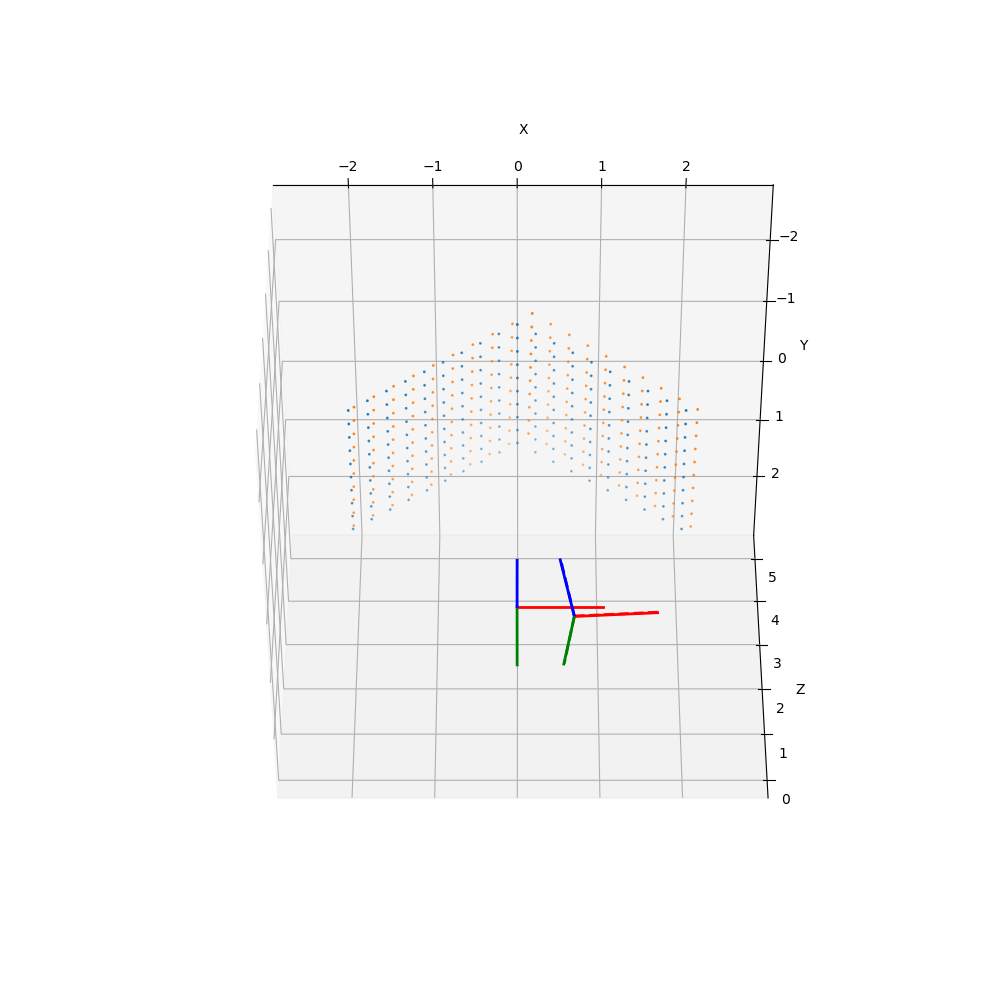

In [192]:
%matplotlib widget
K_result, T2_result, P_result = from_linear(x)

T2_result[:3,3] *= T2_gt[0,3] / T2_result[0,3]
print(T2_gt[0,3] / T2_result[0,3])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(P_gt[:,0], P_gt[:,1], P_gt[:,2], s=1)
ax.scatter(P_result[:,0], P_result[:,1], P_result[:,2], s=1)
plotCoordinateFrame(T1_gt, ax=ax)
plotCoordinateFrame(T2_gt, ax=ax)
plotCoordinateFrame(T2_result, ax=ax, k="--")
set_axes_equal(ax)
ax.set_zlabel("Z")
ax.set_ylabel("Y")
ax.set_xlabel("X")
ax.view_init(-45, -90)
plt.show()